<a href="https://colab.research.google.com/github/AlisonJD/RTACourse/blob/main/Tinybird_CLI_Guide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

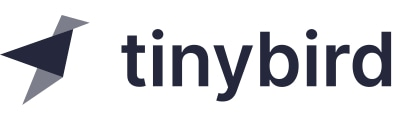
#Principles of Real-Time Analytics Course

#Tinybird CLI Guide

Based on https://docs.tinybird.co/cli.html

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

% cd "/content/gdrive/My Drive/Colab Notebooks/Tinybird"

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/Tinybird


In [3]:
def write_text_to_file(filename, text):
  with open(filename, 'w') as f:
      f.write(text)

In [4]:
!pip install tinybird-cli -q

     |████████████████████████████████| 71 kB 3.9 MB/s 
     |████████████████████████████████| 46 kB 3.2 MB/s 
     |████████████████████████████████| 54 kB 2.3 MB/s 
     |████████████████████████████████| 61 kB 5.1 MB/s 
     |████████████████████████████████| 81 kB 4.9 MB/s 
     |████████████████████████████████| 86 kB 3.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!tb auth

Copy the admin token from https://ui.tinybird.co/tokens and paste it here: 
** Auth successful! 
** Configuration written to .tinyb file, consider adding it to .gitignore


## CLI Help

In [8]:
!tb workspace --help

Usage: tb workspace [OPTIONS] COMMAND [ARGS]...

  Workspace commands

Options:
  --help  Show this message and exit.

Commands:
  ls  List all the workspaces you have access
      to...


In [10]:
!tb datasource --help

Usage: tb datasource [OPTIONS] COMMAND [ARGS]...

  Data sources commands

Options:
  --help  Show this message and exit.

Commands:
  analyze   Analyze a URL or a file before...
  append    Create a data source from a URL,...
  generate  Generates a data source file based on
            a sample CSV file from local disk or
            url
  ls        List data sources
  replace   Replaces the data in a data source...
  rm        Delete a data source
  truncate  Truncate a data source


In [11]:
!tb pipe --help

Usage: tb pipe [OPTIONS] COMMAND [ARGS]...

  Pipes commands

Options:
  --help  Show this message and exit.

Commands:
  append        Append a node to a pipe
  data          Print data returned by a pipe...
  generate      Generates a pipe file based on a
                sql query
  ls            List pipes
  new           Create a new pipe
  rm            Delete a pipe
  set_endpoint  Change the published node of a...
  stats         Print pipe stats
  token_read    Retrieve a token to read a pipe


In [16]:
!tb pipe data --help 

Usage: tb pipe data [OPTIONS] PIPE

  Print data returned by a pipe

  Syntax: tb pipe data <pipe_name> --param_name
  value --param2_name value2 ...

Options:
  --query TEXT         Run SQL over pipe results
  --format [json|csv]  Return format (CSV, JSON)
  --help               Show this message and exit.


In [5]:
!tb push --help

Usage: tb push [OPTIONS] [FILENAMES]...

  Push files to Tinybird

Options:
  --prefix TEXT          Use prefix for all the
                         resources
  --dry-run              Run the command without
                         creating resources on the
                         Tinybird account or any
                         side effect
  --check / --no-check   Enable/Disable output
                         checking, enabled by
                         default
  --push-deps            Push dependencies,
                         disabled by default
  --debug                Print internal
                         representation
  --force                Override pipes when they
                         already exist
  --populate             Populate materialized
                         nodes when pushing them
  --fixtures             Append fixtures to data
                         sources
  --wait                 Wait for populate job to
                         finish, disabled b

In [4]:
!tb pull --help

Usage: tb pull [OPTIONS]

  Retrieve latest versions for project files
  from Tinybird

Options:
  --folder DIRECTORY  Folder where files will be
                      placed
  --match TEXT        Retrieve any resourcing
                      matching the pattern. eg
                      --match _test
  --prefix TEXT       Download only resources with
                      this prefix
  --force             Override existing files
  --help              Show this message and exit.


In [14]:
!tb sql --help

Usage: tb sql [OPTIONS] QUERY

  Run SQL query over data sources and pipes

Options:
  --rows_limit INTEGER       Max number of rows
                             retrieved
  --format [json|csv|human]  Output format
  --stats / --no-stats       Show query stats
  --help                     Show this message and
                             exit.


## Data Source

Download the schema for the [events data source](https://colab.research.google.com/drive/1A9JQ1r8O2QLDsScOMi-hxQ6OGf0W92YK#scrollTo=Y43nKq0dqCqF) and the [products data source](https://colab.research.google.com/drive/1AQvSltEejrY8EPu-WejOiUvCUNz24uPW#scrollTo=dfMt90LfrCLH) from the Tinybird UI (see datasets notebooks on how to create them if you haven't already).

In [ ]:
!cat datasources/events.datasource


SCHEMA >
    `date` DateTime,
    `product_id` String,
    `user_id` Int64,
    `event` String,
    `extra_data` String

ENGINE "MergeTree"
ENGINE_PARTITION_KEY "toYear(date)"
ENGINE_SORTING_KEY "date, cityHash64(extra_data)"
ENGINE_SAMPLING_KEY "cityHash64(extra_data)"


In [ ]:
!cat datasources/products.datasource


SCHEMA >
    `sku` String,
    `color` String,
    `section_id` Int16,
    `title` String

ENGINE "MergeTree"
ENGINE_PARTITION_KEY "substring(sku, 1, 1)"
ENGINE_SORTING_KEY "sku, cityHash64(title)"
ENGINE_SAMPLING_KEY "cityHash64(title)"


The data source can contain three sections:
1. A general **description**
2. The **schema**
3. How the data is **sorted**. Data should be sorted by the most common access pattern. If no ENGINE_SORTING_KEY is set, Tinybird picks one by default, usually Date or DateTime columns.

In [ ]:
filename="datasources/events_top_10_mv.datasource"
text='''
SCHEMA >
    date Date,
    top_10 AggregateFunction(topK(10), String)

ENGINE AggregatingMergeTree
ENGINE_SORTING_KEY date
'''

write_text_to_file(filename, text)

In [ ]:
!tb push datasources/events_top_10_mv.datasource

** Processing datasources/events_top_10_mv.datasource
** Building dependencies
** Running events_top_10_mv 
** 'events_top_10_mv' created
** Not pushing fixtures


# Pipe

You don’t usually use the data exactly as it arrives. You usually need to transform the data by generating a live materialized view.

Here we create a data pipe `top_product_per_day.pipe` that transforms the data as it’s inserted.

In [18]:
filename="pipes/top_product_per_day.pipe"
text='''
NODE only_buy_events
DESCRIPTION >
    filter all the buy events

SQL >
    SELECT
        toDate(date) date,
        product_id
    FROM events
    WHERE event = 'buy'

NODE top_per_day
SQL >
   SELECT 
      date,
      topKState(10)(product_id) top_10
    FROM only_buy_events
    GROUP BY date

TYPE materialized
DATASOURCE events_top_10_mv
'''

write_text_to_file(filename, text)

Each pipe can have one or more nodes. In this pipe we define two nodes: `only_buy_events` and `top_per_day`.

- `only_buy_events` filters “buy” events
- `top_per_day` runs the aggregation.


The pattern to define a pipeline is: 
- use NODE to start a new node
- use SQL > to define the SQL for that node. 

Notice you can use other nodes inside the SQL. In this example, the second node uses the first one `only_buy_events`.

In [19]:
!tb push pipes/top_product_per_day.pipe --populate --skip-table-checks

** Processing pipes/top_product_per_day.pipe
** Building dependencies
** Running top_product_per_day 
** Materialized node 'top_per_day' used the Data Source 'events_top_10_mv'
** Populating job url https://api.tinybird.co/v0/jobs/aa78d4d9-ddbf-4774-9f93-3f0db0d1b3ec
** 'top_product_per_day' created
** Not pushing fixtures


# Endpoint

Endpoints are the way you expose the data to be consumed.


In [20]:
filename="endpoints/top_products.pipe"
text='''
NODE endpoint
DESCRIPTION >
    returns top product per day
SQL >
    %
    SELECT
        date,
        topKMerge(10)(top_10) AS top_10
    FROM top_product_per_day
    WHERE date between {{Date(start)}} AND {{Date(end)}}
    GROUP BY date
'''

write_text_to_file(filename, text)

In [21]:
!tb push endpoints/top_products.pipe --populate

** Processing endpoints/top_products.pipe
** Building dependencies
** Running top_products 
** => Test endpoint at https://api.tinybird.co/v0/pipes/top_products.json
** 'top_products' created
** Not pushing fixtures


https://api.tinybird.co/v0/pipes/top_products.json?start=2019-01-01&end=2019-01-08

In [23]:
!tb pipe data top_products --start '2019-01-01' --end '2019-01-08' --format CSV

"date","top_10"
"2019-01-01","['634fca1c-1aaa-11eb-916f-acde48001122','69dec162-1aaa-11eb-acb8-acde48001122','6b81255a-1aaa-11eb-9191-acde48001122','631cf3b4-1aaa-11eb-a7fc-acde48001122','634f35ac-1aaa-11eb-8825-acde48001122','64c6e100-1aaa-11eb-a13b-acde48001122','6354b180-1aaa-11eb-a56f-acde48001122','6b4b68f4-1aaa-11eb-82de-acde48001122','689caa1c-1aaa-11eb-9214-acde48001122','6c1d2afe-1aaa-11eb-8c16-acde48001122']"
"2019-01-02","['69f21bfe-1aaa-11eb-842e-acde48001122','65fd84b6-1aaa-11eb-9c9e-acde48001122','6bed3346-1aaa-11eb-be4c-acde48001122','65a2a886-1aaa-11eb-b626-acde48001122','6a1b984c-1aaa-11eb-be1f-acde48001122','6a1a1a00-1aaa-11eb-8ec7-acde48001122','69b52dfa-1aaa-11eb-b924-acde48001122','63434cf6-1aaa-11eb-945d-acde48001122','664629dc-1aaa-11eb-a460-acde48001122','64148afa-1aaa-11eb-9f2f-acde48001122']"
"2019-01-03","['6718d2b0-1aaa-11eb-82d1-acde48001122','675b3428-1aaa-11eb-bec5-acde48001122','6c05cfba-1aaa-11eb-b1b3-acde48001122','6c4bc13e-1aaa-11eb-ac60-acde48001122'